## Part 2: Normalization and background removal

*by Morgane Desmau & Marco Alsina*

*Last update: May 2021*

The following notebook explains the following steps:

1. Normalization of a spectrum.
3. Background removal of spectrum.

**Important:** This tutorial assumes you have succesfully completed the previous tutorial in the series:
- [Part 1: Basics of data processing](01.basics_data_processing.ipynb)

In [1]:
# checking version of araucaria and dependencies
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.8


### 1. Retrieving the database filepath

`araucaria` contains spectra from different beamlines as examples and for testing purposes.
The [testdata](../testdata_module.rst) module offers routines to retrieve the respective filepaths.

In this case we will be reading and processing a sample from a minerals database measured at the Fe K-edge in the P65 beamline of DESY, Hamburg (data kindly provided by Morgane Desmau):

1. Fe_database.h5

We first retrieve the filepath to the database.

In [2]:
# retrieving filepath
from pathlib import Path
from araucaria.testdata import get_testpath

fpath = get_testpath('Fe_database.h5')

# checking that filepath is a Path class
isinstance(fpath, Path)

True

<div class="alert alert-info">
    
    **Note**
    
    If you prefer to process your own database, just modify the filepath to point to the location of your file.
</div>

### 2. Summarizing a HDF5 database

It is illustrative to first summarize the data contained in an `HDF5` database. Here we use the [summary_hdf5()](../io/io_hdf5.rst#araucaria.io.io_hdf5.summary_hdf5) function to produce a [Report](../main/main_report.rst#araucaria.main.report.Report) with the contents of the database.

In [3]:
# summarizing database
from araucaria.io import summary_hdf5

report = summary_hdf5(fpath)
report.show()

id  dataset                 mode    n   
1   FeIISO4_20K             mu      5   
2   Fe_Foil                 mu_ref  5   
3   Ferrihydrite_20K        mu      5   
4   Goethite_20K            mu      5   
5   Goethite_20K_10spectra  mu      10  


As seen in the report, spectra in the database were acquired in transmission mode (mu), and were merged from at least 5 scans. `araucaria` also distinguises a reference measurement (mu_ref), which is convenient to verify that spectra is properly aligned.

The [read_hdf5()](../io/io_hdf5.rst#araucaria.io.io_hdf5.read_hdf5) function allows us to read a single [Group](../main/main_group.rst#araucaria.main.group.Group) from a HDF5 database.
In this case we will read the sample of ferrous sulfate measured at 20 K.

In [4]:
from araucaria import Group
from araucaria.io import read_hdf5

name  = 'FeIISO4_20K'
group = read_hdf5(fpath, name)

# checking the group class
isinstance(group, Group)

True

### 4. Spectrum normalization

Analysis and comparison of spectra acquired under different conditions requires normalization.
In this regard, XAFS spectra is commonly normalized by setting the absorption edge step to one ($\Delta \mu_0 \sim 1.0$).
Such approach depends on the value of the absorption threshold ($E_0$).

The [find_e0()](../xas/xas_normalize.rst#araucaria.xas.normalize.find_e0) function allows to find $E_0$ for a single scan group:

In [5]:
from araucaria.xas import find_e0

e0 = find_e0(group)
print('e0 value is %1.3f eV' % e0) 

e0 value is 7124.723 eV


We can use the previous value to normalize the spectrum and automatically update the group with the [pre_edge()](../xas/xas_normalize.rst#araucaria.xas.normalize.pre_edge) function.

Here we use a dictionary to specifiy the normalization parameters, including the pre-edge and post-edge fitting ranges, as well as the coefficients for the pre-edge Victoreen and the post-edge polynomial functions.

<div class="alert alert-info">
    
    **Note**
    
    We specified the upper end of the post-edge polynomial to be `inf`.
    This value defaults to the maximum recorded energy in the scan.
    
    Please check the documentation of [pre_edge()](../xas/xas_normalize.rst#araucaria.xas.normalize.pre_edge) for further details.
</div>

In [6]:
from numpy import inf
from araucaria.xas import pre_edge
from araucaria.plot import fig_pre_edge

# pre-edge parameters
pre_edge_kws = {'pre_range' : [-160, -40],
                'post_range': [150, inf],
                'nvict'     : 2,
                'nnorm'     : 3}

pre_data = pre_edge(group, e0=e0, update=True, **pre_edge_kws)
print('edge step is %1.4f a.u.' % group.edge_step)

edge step is 0.1821 a.u.


Finally we can plot the normalized spectrum with the [fig_pre_edge()](../plot_module.rst#araucaria.plot.fig_pre_edge.fig_pre_edge) function. The function accepts a dictionary of parameters for the figure, so in this case we specify the figure size with the `figsize` key.

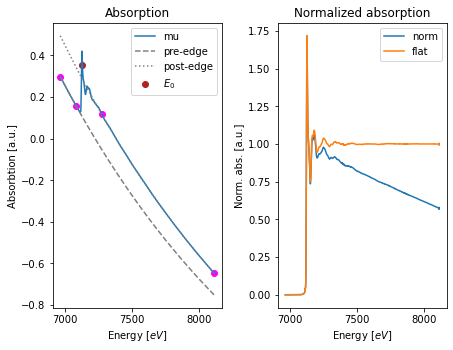

In [7]:
import matplotlib.pyplot as plt

# figure size in inches
fig_kws  = {'figsize' : (6.4, 4.8)} 

fig, ax  = fig_pre_edge(group, **fig_kws)
plt.show()

### 5. Background removal

Once a XAFS spectrum is normalized we can compute the Extended X-ray Fine Structure (EXAFS) $\chi(k)$. For this we need to remove background signal that accompanies the EXAFS. `araucaria` implements background removal with the [autobk()](../xas/xas_autobk.rst#araucaria.xas.autobk.autobk) function.
Note that we are using a dictionary to provide that parameters for the function. Plese check the documentation of [autobk()](../xas/xas_autobk.rst#araucaria.xas.autobk.autobk) for further details.

In [8]:
from araucaria.xas import autobk

# autobk parameters
autobk_kws = {'rbkg'    : 1.0,
              'k_range' : [0, 14],
              'kweight' : 2,
              'win'     : 'hanning',
              'dk'      : 0.1,
              'nclamp'  : 2,
              'clamp_lo': 1,
              'clamp_hi': 1}

# background removal
autbk_data = autobk(group, update=True, **autobk_kws)

Once we have removed the background signal, we can visualize it along with the $\chi(k)$ spectrum using the [fig_autobk()](../plot_module.rst#araucaria.plot.fig_autobk.fig_autobk) function. The function also accepts a dictionary of parameters for the figure, provided in this case with the `fig_kws` dictionary.

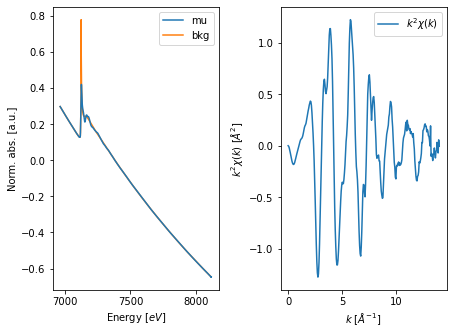

In [9]:
# plot background and EXAFS
from araucaria.plot import fig_autobk

fig, ax = fig_autobk(group, show_window=False, **fig_kws)
plt.show()